In [15]:
# Setup and Data Loading - White Wine Only 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import pymc as pm
import arviz as az
import scipy.stats as stats

import sys
sys.path.append('..')
import bayes_ordinal as bo

import multiprocessing as mp
mp.set_start_method('spawn', force=True)

# Set plotting style (same as your notebook)
plt.style.use('default')
sns.set_palette("husl")

print("WHITE WINE QUALITY COMPLETE BAYESIAN WORKFLOW")
print("="*60)
data_path = Path("../Dataset")
white_wine = pd.read_csv(data_path / "winequality-white.csv", sep=';')

print(f"White wine data: {white_wine.shape}")

WHITE WINE QUALITY COMPLETE BAYESIAN WORKFLOW
White wine data: (4898, 12)


In [2]:
# Clean the data
data_clean = white_wine.copy()
data_clean = data_clean.fillna(data_clean.median())
print(f"Cleaned dataset shape: {data_clean.shape}")

# Check response variable
print(f"Response range: {data_clean['quality'].min()} to {data_clean['quality'].max()}")
print(f"Number of categories: {data_clean['quality'].nunique()}")
print(f"Features: {list(data_clean.columns[:-1])}")

# Display response distribution
print("\nResponse distribution:")
print(data_clean['quality'].value_counts().sort_index())

# Prepare features
feature_cols = list(data_clean.columns[:-1])  # All except 'quality'
X = data_clean[feature_cols].values
y = data_clean['quality'].values

# Ensure target starts from 0
if y.min() > 0:
    y = y - y.min()
print(f"Target adjusted to start from 0: {y.min()} to {y.max()}")

Cleaned dataset shape: (4898, 12)
Response range: 3 to 9
Number of categories: 7
Features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

Response distribution:
quality
3      20
4     163
5    1457
6    2198
7     880
8     175
9       5
Name: count, dtype: int64
Target adjusted to start from 0: 0 to 6


In [3]:
print("\n2. Data Validation and Preprocessing...")
print("=" * 50)

# Validate data using our package
validation_results = bo.validate_ordinal_data(y, X)
print("Data validation completed")

# Standardize numerical features
X_standardized, scaler = bo.standardize_features(X)
print("Features standardized")

# Encode categorical features (wine dataset has no categorical features, so this is just for consistency)
categorical_cols = []  # No categorical features in wine dataset
X_encoded, encoders = bo.encode_categorical_features(X_standardized, categorical_cols)
print("Categorical features encoded")

print(f"Final data shape: X={X_encoded.shape}, y={y.shape}")
print(f"Number of ordinal categories: {len(np.unique(y))}")


2. Data Validation and Preprocessing...
Data validation completed
Features standardized
Categorical features encoded
Final data shape: X=(4898, 11), y=(4898,)
Number of ordinal categories: 7


In [4]:
print("\n3. Data Exploration and Analysis...")
print("=" * 50)

# Feature summary
print("Feature Summary:")
for i, col in enumerate(feature_cols):
    print(f"  {col}: mean={X_encoded[:, i].mean():.3f}, std={X_encoded[:, i].std():.3f}")

# Target distribution analysis for informed priors
print(f"\nTarget Distribution Analysis for Informed Priors:")
target_counts = np.bincount(y)
target_props = target_counts / len(y)
cumulative_props = np.cumsum(target_props)

print("Target distribution:")
for i, (count, prop, cum_prop) in enumerate(zip(target_counts, target_props, cumulative_props)):
    print(f"  Class {i}: {count} ({prop:.3f}) - Cumulative: {cum_prop:.3f}")

# Calculate informed cutpoint priors based on data
z_scores = stats.norm.ppf(cumulative_props[:-1])  # Exclude last (always 1.0)
print(f"\nInformed cutpoint priors (z-scores): {z_scores}")

# Correlation analysis
print(f"\nFeature Correlations with Target:")
for i, feature in enumerate(feature_cols):
    corr = np.corrcoef(X_encoded[:, i], y)[0, 1]
    print(f"  {feature}: {corr:.3f}")


3. Data Exploration and Analysis...
Feature Summary:
  fixed acidity: mean=-0.000, std=1.000
  volatile acidity: mean=0.000, std=1.000
  citric acid: mean=0.000, std=1.000
  residual sugar: mean=-0.000, std=1.000
  chlorides: mean=0.000, std=1.000
  free sulfur dioxide: mean=-0.000, std=1.000
  total sulfur dioxide: mean=-0.000, std=1.000
  density: mean=0.000, std=1.000
  pH: mean=-0.000, std=1.000
  sulphates: mean=-0.000, std=1.000
  alcohol: mean=-0.000, std=1.000

Target Distribution Analysis for Informed Priors:
Target distribution:
  Class 0: 20 (0.004) - Cumulative: 0.004
  Class 1: 163 (0.033) - Cumulative: 0.037
  Class 2: 1457 (0.297) - Cumulative: 0.335
  Class 3: 2198 (0.449) - Cumulative: 0.784
  Class 4: 880 (0.180) - Cumulative: 0.963
  Class 5: 175 (0.036) - Cumulative: 0.999
  Class 6: 5 (0.001) - Cumulative: 1.000

Informed cutpoint priors (z-scores): [-2.64510328 -1.78215243 -0.42661319  0.7843586   1.78971719  3.08410582]

Feature Correlations with Target:
  fixed

In [5]:
print("\n4. Prior Specification...")
print("=" * 50)

# Define informed priors for the cumulative model
priors = {
    "beta": [0, 0.3],       # [mu, sigma] for beta - tighter priors
    "sigma": 0.3,           # Smaller sigma for stability
    "mu": z_scores,         # Data-informed cutpoint means
    "constrained_uniform": False
}

print("Prior specifications (informed by data):")
print(f"  beta: {priors['beta']} (coefficient mean=0, std=0.5)")
print(f"  sigma: {priors['sigma']} (cutpoint prior std=0.5)")
print(f"  mu: {priors['mu']} (data-informed cutpoint means)")
print(f"  constrained_uniform: {priors['constrained_uniform']}")


4. Prior Specification...
Prior specifications (informed by data):
  beta: [0, 0.3] (coefficient mean=0, std=0.5)
  sigma: 0.3 (cutpoint prior std=0.5)
  mu: [-2.64510328 -1.78215243 -0.42661319  0.7843586   1.78971719  3.08410582] (data-informed cutpoint means)
  constrained_uniform: False


In [6]:
print("STEP 3: Building models")
print("=" * 60)
K = len(np.unique(y))

logit_model = bo.cumulative_model(
    y=y,
    X=X_encoded,
    K=K,
    link="logit",
    priors=priors,
    model_name="wine_logit",
    prior_type="fixed_sigma",
    feature_names=feature_cols
)
print(" Logit model built successfully")

print("\nBuilding probit model for prior predictive...")
probit_model = bo.cumulative_model(
    y=y,
    X=X_encoded,
    K=K,
    link="probit",
    priors=priors,  # Will be automatically adjusted for probit scale
    model_name="wine_probit",
    prior_type="fixed_sigma",
    feature_names=feature_cols
)
print(" Probit model built successfully")
print(" Note: Prior scales automatically adjusted for probit link")


STEP 3: Building models
 Logit model built successfully

Building probit model for prior predictive...
 Probit model built successfully
 Note: Prior scales automatically adjusted for probit link



Model Structure:
Model Structure (PyMC Graphviz):


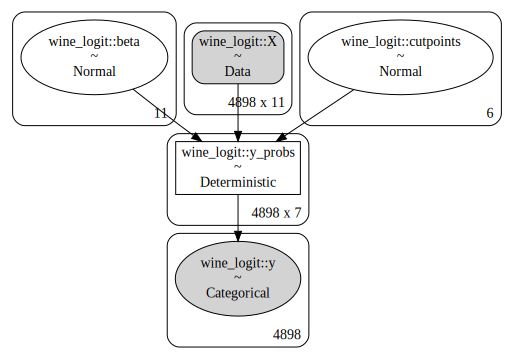

Logit model Graphviz visualization displayed successfully!


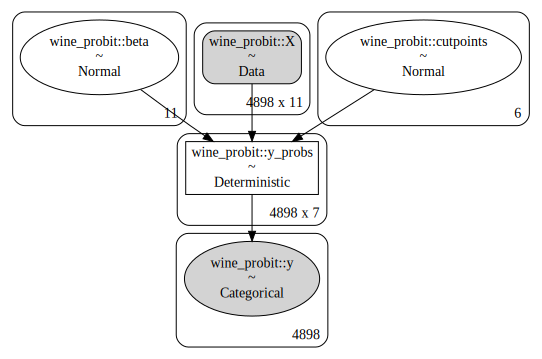

Probit model Graphviz visualization displayed successfully!


In [7]:
# Display model structure
print("\nModel Structure:")
print("Model Structure (PyMC Graphviz):")

model_graph_logit = pm.model_to_graphviz(logit_model)
display(model_graph_logit)
print("Logit model Graphviz visualization displayed successfully!")
model_graph_probit = pm.model_to_graphviz(probit_model)
display(model_graph_probit)
print("Probit model Graphviz visualization displayed successfully!")


6. Prior Predictive Checks...
Running prior predictive check for logit model...
 Running prior predictive check for model: wine_logit
 Drawing 1000 samples from prior predictive distribution


Sampling: [wine_logit::beta, wine_logit::cutpoints, wine_logit::y]


 Successfully sampled 1000 prior predictive draws


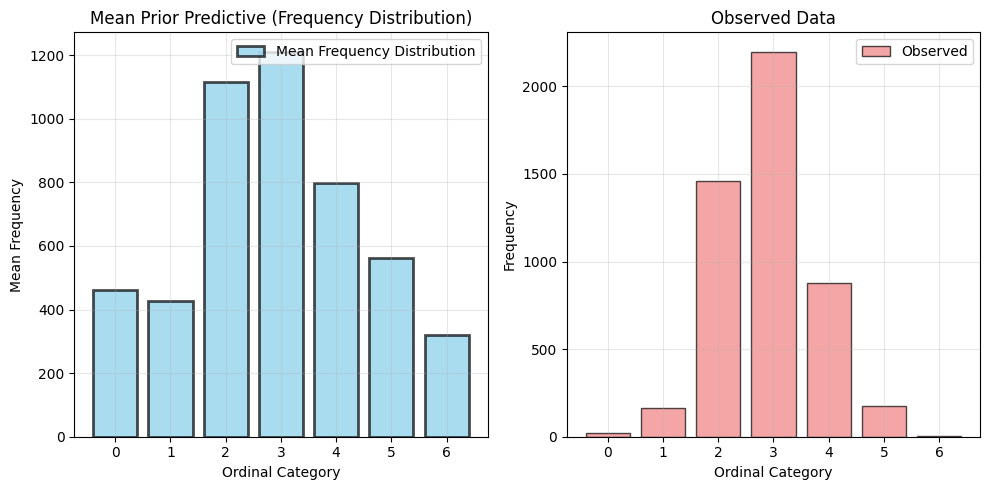

Sampling: [wine_probit::beta, wine_probit::cutpoints, wine_probit::y]


 Prior predictive plots generated successfully
 Prior predictive check completed successfully!
 Results stored in InferenceData object
Running prior predictive check for probit model...
 Running prior predictive check for model: wine_probit
 Drawing 1000 samples from prior predictive distribution
 Successfully sampled 1000 prior predictive draws


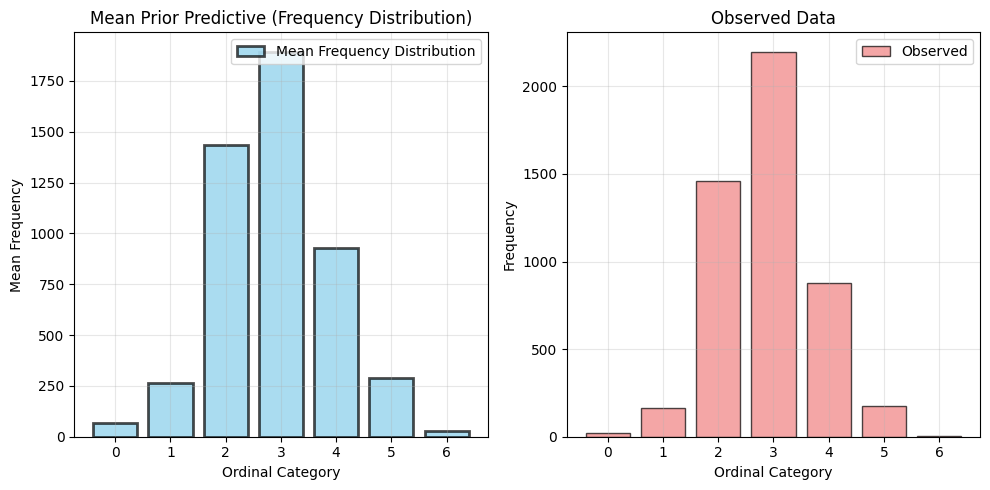

 Prior predictive plots generated successfully
 Prior predictive check completed successfully!
 Results stored in InferenceData object
Prior predictive checks completed for both models!


In [8]:
print("\n6. Prior Predictive Checks...")
print("=" * 50)

# Run prior predictive checks for logit model
print("Running prior predictive check for logit model...")
prior_pred_logit = bo.run_prior_predictive(
    model=logit_model,
    draws=1000,
    plot=True,
    y_obs=y,
    model_name="wine_logit",
)

# Run prior predictive checks for probit model
print("Running prior predictive check for probit model...")
prior_pred_probit = bo.run_prior_predictive(
    model=probit_model,
    draws=1000,
    plot=True,
    y_obs=y,
    model_name="wine_probit",
)

print("Prior predictive checks completed for both models!")

In [9]:
print("\n7. Model Fitting...")
print("=" * 50)

# Fit logit model with enhanced parameters
print("Fitting logit model...")
idata_logit = bo.fit_ordinal_model(
    model=logit_model,
    chains=4,
    draws=2000,
    tune=1000,  # More tuning for stability
    target_accept=0.8,  # Higher acceptance rate
    max_treedepth=10,    # More tree depth
    random_seed=42,
    init="adapt_diag",    # Better initialization
    enable_log_likelihood=True,        # ← ADD THIS!
    enable_posterior_predictive=True,
    cores=1
)
print("Logit model fitting completed")
print(f"InferenceData shape: {idata_logit.posterior['wine_logit::beta'].shape}")

# Fit probit model with enhanced parameters
print("Fitting probit model...")
idata_probit = bo.fit_ordinal_model(
    model=probit_model,
    chains=4,
    draws=2000,
    tune=1000,
    target_accept=0.8,
    max_treedepth=10,
    random_seed=42,
    init="adapt_diag",
    enable_log_likelihood=True,        # ← ADD THIS!
    enable_posterior_predictive=True,
    cores=1
)
print("Probit model fitting completed")
print(f"InferenceData shape: {idata_probit.posterior['wine_probit::beta'].shape}")


7. Model Fitting...
Fitting logit model...


Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [wine_logit::beta, wine_logit::cutpoints]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 218 seconds.


Logit model fitting completed
InferenceData shape: (4, 2000, 11)
Fitting probit model...


Initializing NUTS using adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [wine_probit::beta, wine_probit::cutpoints]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1356 seconds.


Probit model fitting completed
InferenceData shape: (4, 2000, 11)



8. Computational Validation and Model Verification...

1. Computational Issues Diagnosis:
 Diagnosing computational issues...
   R-hat: 0 parameters with issues
   ESS: 0 parameters with low ESS
   Divergences: 0 (0.00%)
   Energy plot: Created successfully

 No issues detected - model looks good!
 Diagnosing computational issues...


Sampling: [wine_logit::beta, wine_logit::cutpoints, wine_logit::y]
Sampling: [wine_logit::beta, wine_logit::cutpoints, wine_logit::y]
Sampling: [wine_logit::beta, wine_logit::cutpoints, wine_logit::y]
Sampling: [wine_logit::beta, wine_logit::cutpoints, wine_logit::y]
Sampling: [wine_logit::beta, wine_logit::cutpoints, wine_logit::y]
Sampling: [wine_logit::beta, wine_logit::cutpoints, wine_logit::y]


   R-hat: 0 parameters with issues
   ESS: 0 parameters with low ESS
   Divergences: 0 (0.00%)
   Energy plot: Created successfully

 No issues detected - model looks good!

2. Multimodality Checks:
Logit model:
 Checking for multimodality...
  wine_logit::beta:  MULTIMODAL (5 peaks)
  wine_logit::cutpoints:  MULTIMODAL (6 peaks)

  2 variables show multimodality

Probit model:
 Checking for multimodality...
  wine_probit::beta:  MULTIMODAL (5 peaks)
  wine_probit::cutpoints:  MULTIMODAL (6 peaks)

  2 variables show multimodality

3. Fake Data Simulation Tests (Model Implementation Validation):
Testing logit model implementation...
 Running fake data simulation (10 simulations)...
   Simulation 1: Success
   Simulation 2: Success
   Simulation 3: Success
   Simulation 4: Success
   Simulation 5: Success


Sampling: [wine_logit::beta, wine_logit::cutpoints, wine_logit::y]
Sampling: [wine_logit::beta, wine_logit::cutpoints, wine_logit::y]
Sampling: [wine_logit::beta, wine_logit::cutpoints, wine_logit::y]
Sampling: [wine_logit::beta, wine_logit::cutpoints, wine_logit::y]


   Simulation 6: Success
   Simulation 7: Success
   Simulation 8: Success
   Simulation 9: Success
   Simulation 10: Success

 Simulation Results:
  Total: 10
  Successful: 10
  Failed: 0
  Success Rate: 100.0%
 All simulations successful! Model implementation looks good.
Testing probit model implementation...
 Running fake data simulation (10 simulations)...


Sampling: [wine_probit::beta, wine_probit::cutpoints, wine_probit::y]
Sampling: [wine_probit::beta, wine_probit::cutpoints, wine_probit::y]


   Simulation 1: Success
   Simulation 2: Success


Sampling: [wine_probit::beta, wine_probit::cutpoints, wine_probit::y]
Sampling: [wine_probit::beta, wine_probit::cutpoints, wine_probit::y]


   Simulation 3: Success
   Simulation 4: Success


Sampling: [wine_probit::beta, wine_probit::cutpoints, wine_probit::y]
Sampling: [wine_probit::beta, wine_probit::cutpoints, wine_probit::y]


   Simulation 5: Success
   Simulation 6: Success


Sampling: [wine_probit::beta, wine_probit::cutpoints, wine_probit::y]
Sampling: [wine_probit::beta, wine_probit::cutpoints, wine_probit::y]


   Simulation 7: Success
   Simulation 8: Success


Sampling: [wine_probit::beta, wine_probit::cutpoints, wine_probit::y]
Sampling: [wine_probit::beta, wine_probit::cutpoints, wine_probit::y]


   Simulation 9: Success
   Simulation 10: Success

 Simulation Results:
  Total: 10
  Successful: 10
  Failed: 0
  Success Rate: 100.0%
 All simulations successful! Model implementation looks good.

 COMPUTATIONAL VALIDATION RESULTS:
Logit Model:
   Implementation test: 10/10 (100.0%)
Probit Model:
   Implementation test: 10/10 (100.0%)

 COMPUTATIONAL VALIDATION PASSED - Safe to proceed with analysis
 Computational validation completed


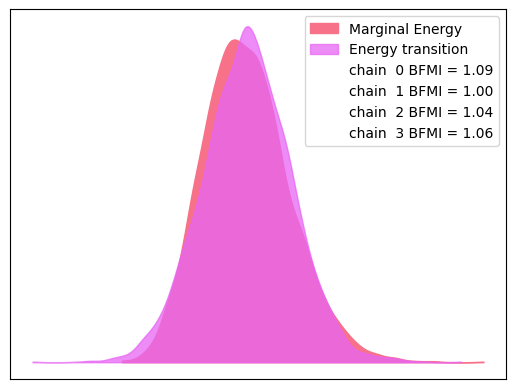

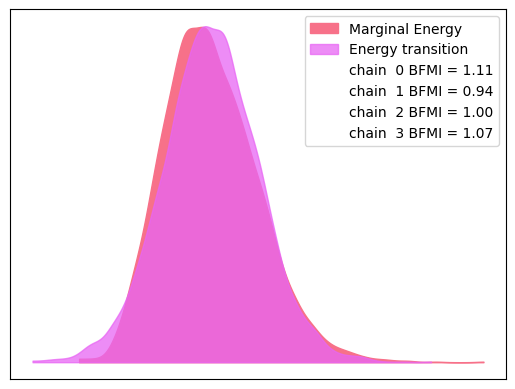

In [10]:
print("\n8. Computational Validation and Model Verification...")
print("=" * 60)

# Import computational validation functions
from bayes_ordinal.workflow.computation import (
    diagnose_computational_issues,
    check_multimodality,
    fake_data_simulation
)

# Diagnose computational issues
print("\n1. Computational Issues Diagnosis:")
logit_comp_issues = diagnose_computational_issues(idata_logit)
probit_comp_issues = diagnose_computational_issues(idata_probit)

# Check for multimodality
print("\n2. Multimodality Checks:")
print("Logit model:")
logit_multimodal = check_multimodality(
    idata_logit, 
    var_names=["wine_logit::beta", "wine_logit::cutpoints"]
)

print("\nProbit model:")
probit_multimodal = check_multimodality(
    idata_probit, 
    var_names=["wine_probit::beta", "wine_probit::cutpoints"]
)

# Fake data simulation tests (MOST IMPORTANT)
print("\n3. Fake Data Simulation Tests (Model Implementation Validation):")
print("Testing logit model implementation...")
logit_fake_data = fake_data_simulation(logit_model, n_simulations=10)

print("Testing probit model implementation...")
probit_fake_data = fake_data_simulation(probit_model, n_simulations=10)

print(f"\n COMPUTATIONAL VALIDATION RESULTS:")
print(f"Logit Model:")
print(f"   Implementation test: {logit_fake_data['n_successful']}/{logit_fake_data['n_simulations']} ({logit_fake_data['n_successful']/logit_fake_data['n_simulations']*100:.1f}%)")
print(f"Probit Model:")
print(f"   Implementation test: {probit_fake_data['n_successful']}/{probit_fake_data['n_simulations']} ({probit_fake_data['n_successful']/probit_fake_data['n_simulations']*100:.1f}%)")

# Determine if we can proceed
all_passed = (logit_fake_data['n_successful'] == logit_fake_data['n_simulations'] and 
              probit_fake_data['n_successful'] == probit_fake_data['n_simulations'])

if all_passed:
    print("\n COMPUTATIONAL VALIDATION PASSED - Safe to proceed with analysis")
else:
    print("\n  COMPUTATIONAL ISSUES DETECTED - Review model implementation")
    
print(" Computational validation completed")


9. Model Diagnostics...
Running comprehensive convergence diagnostics...
 Log likelihood available for LOO/WAIC calculations
  Max R-hat: 1.000
 Diagnostic summary completed
  Model: wine_logit
  Summary shape: (34303, 12)
  R-hat column exists: True
  R-hat values: [1. 1. 1. ... 1. 1. 1.]
Creating diagnostic plots...
 Creating energy plot...


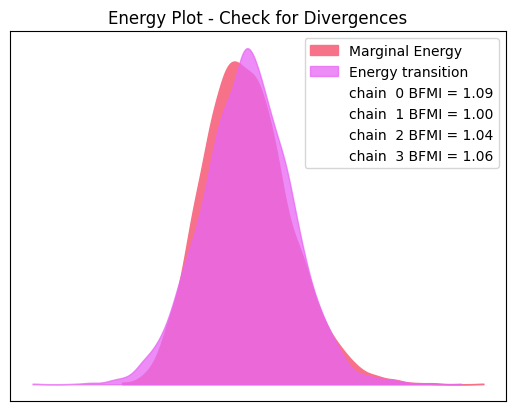

 Creating trace plots...


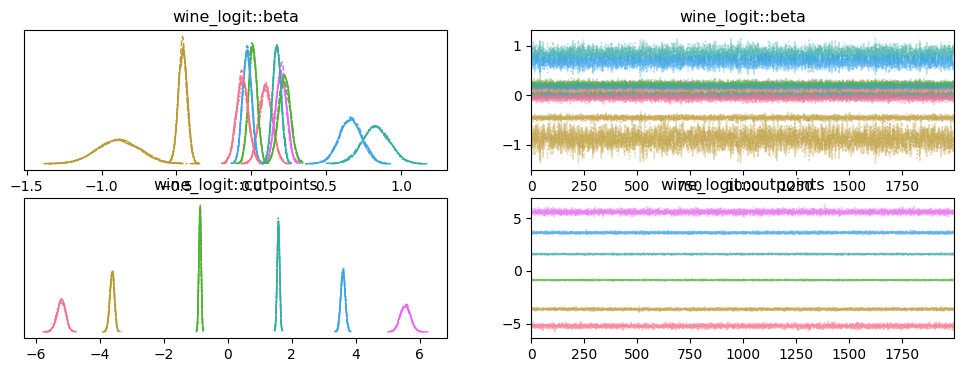

 Creating rank plots...


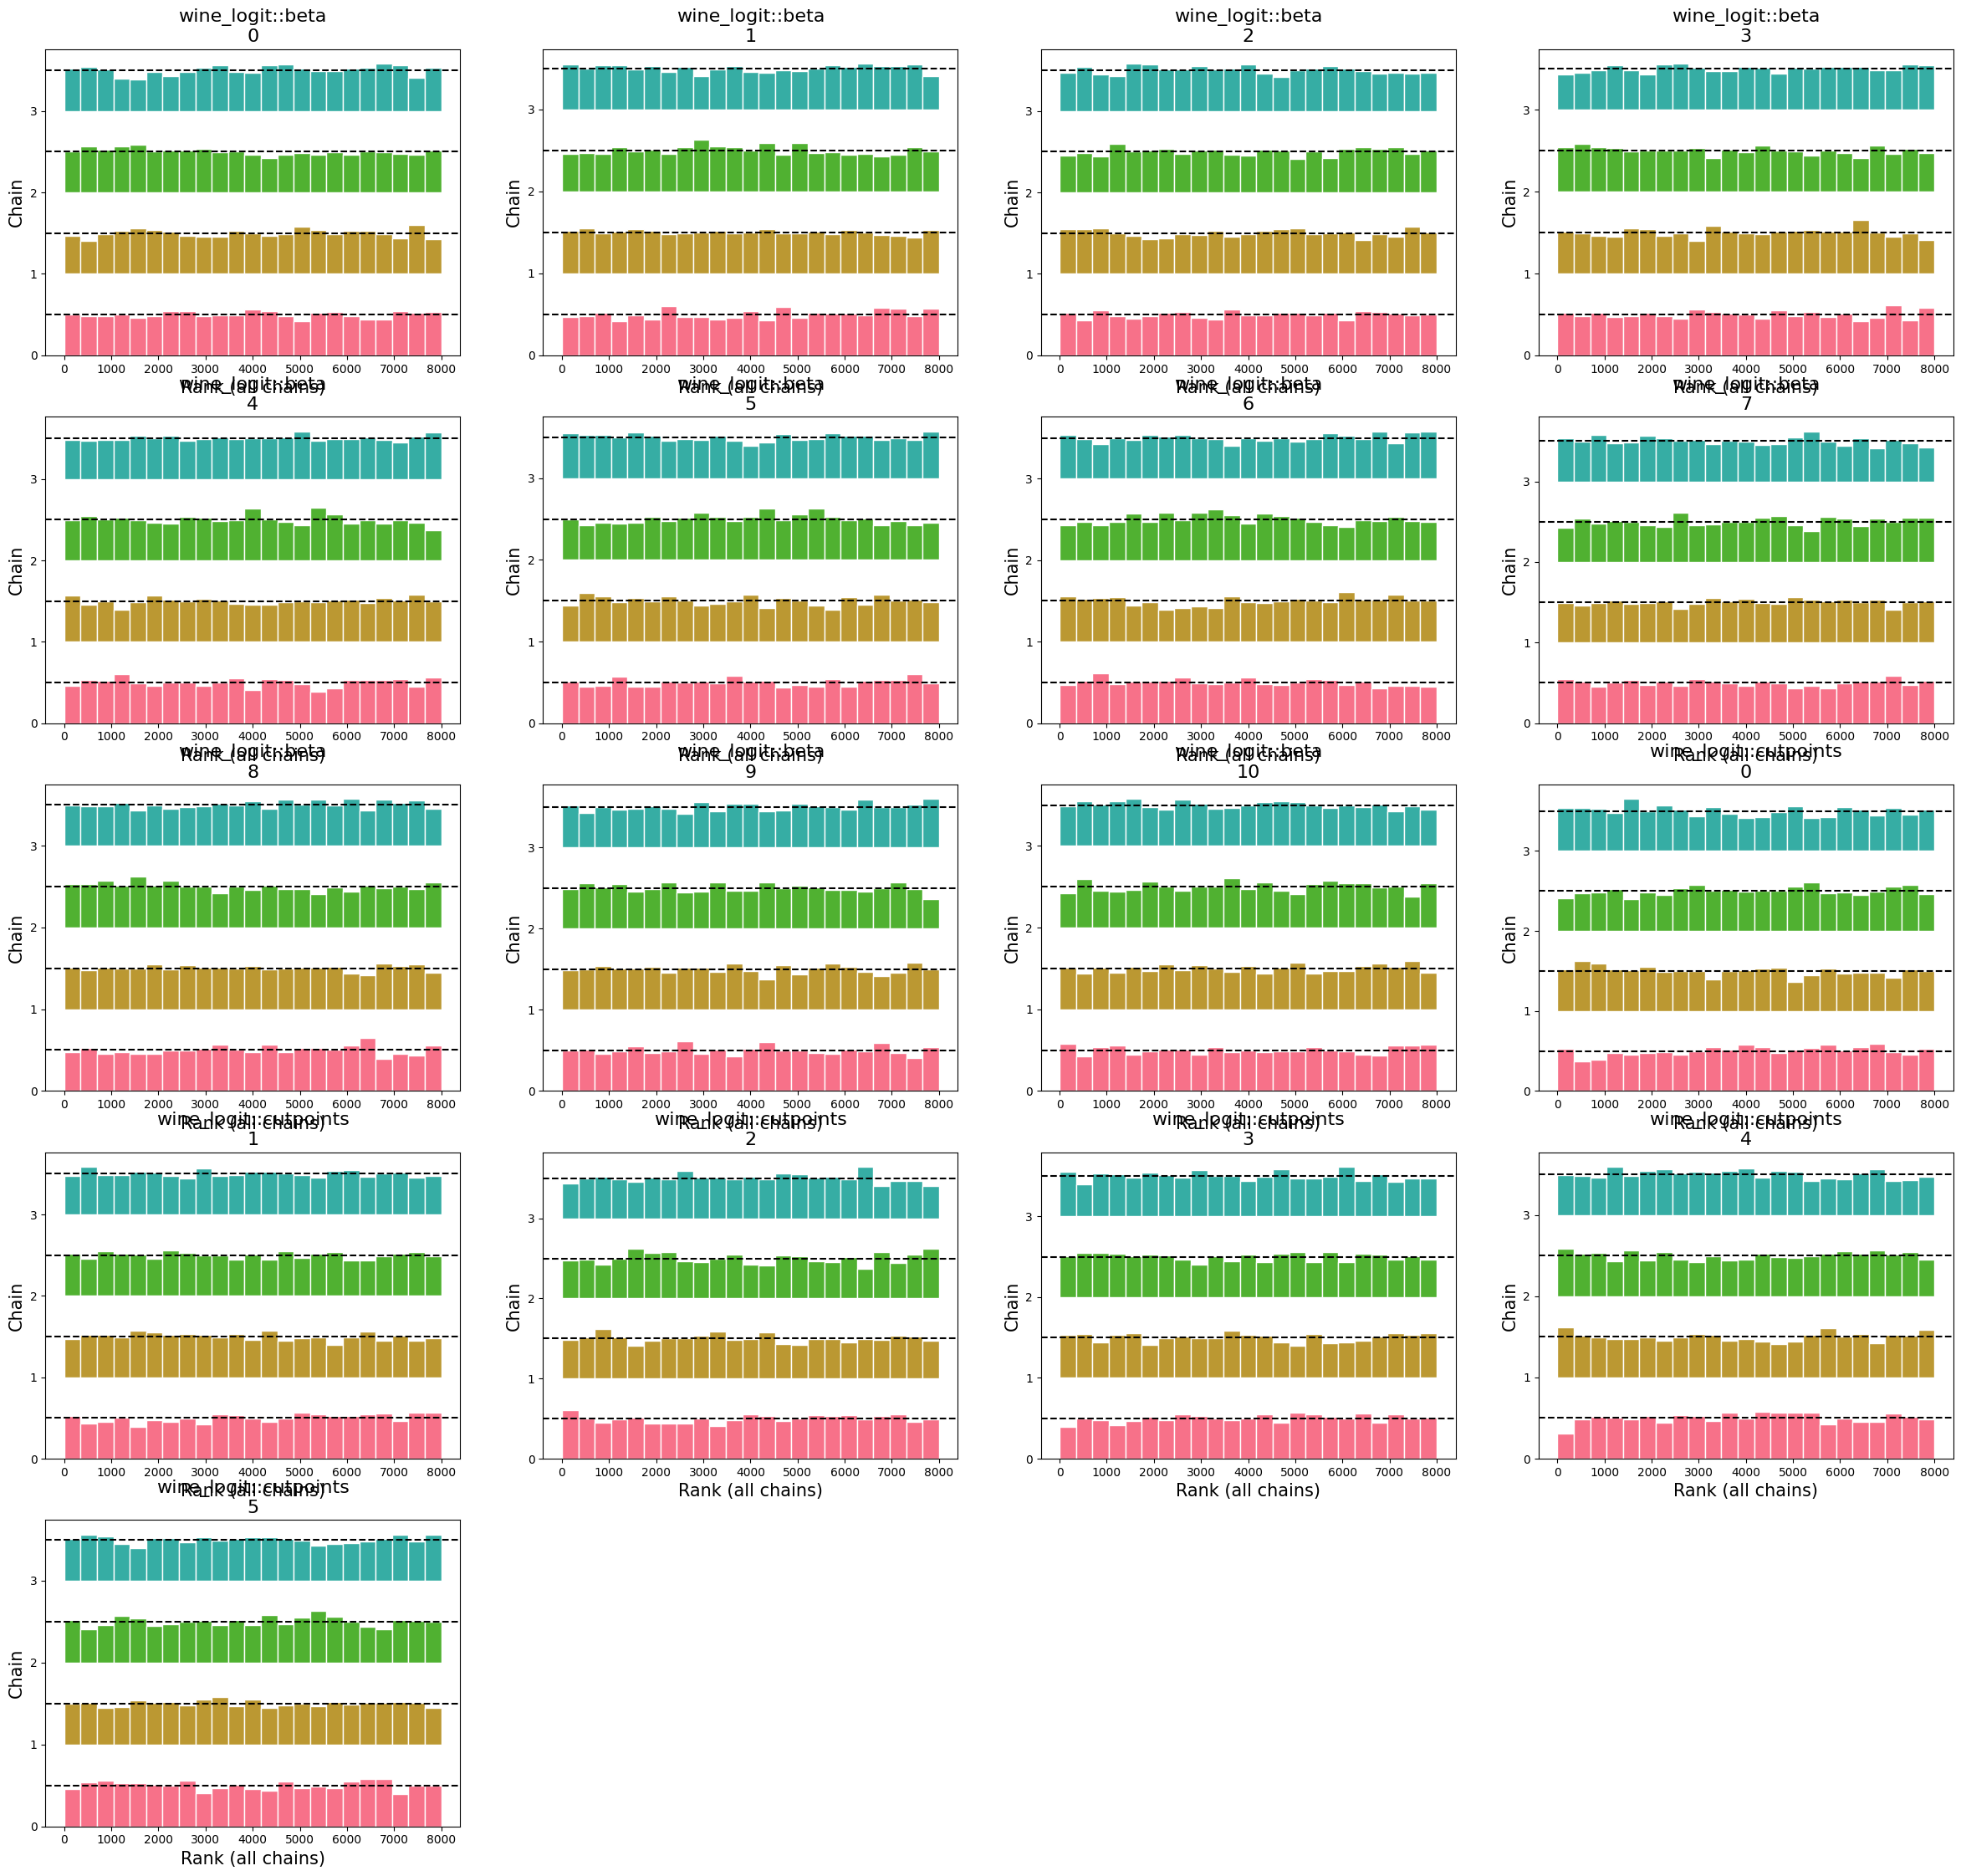

 Creating autocorrelation plots...


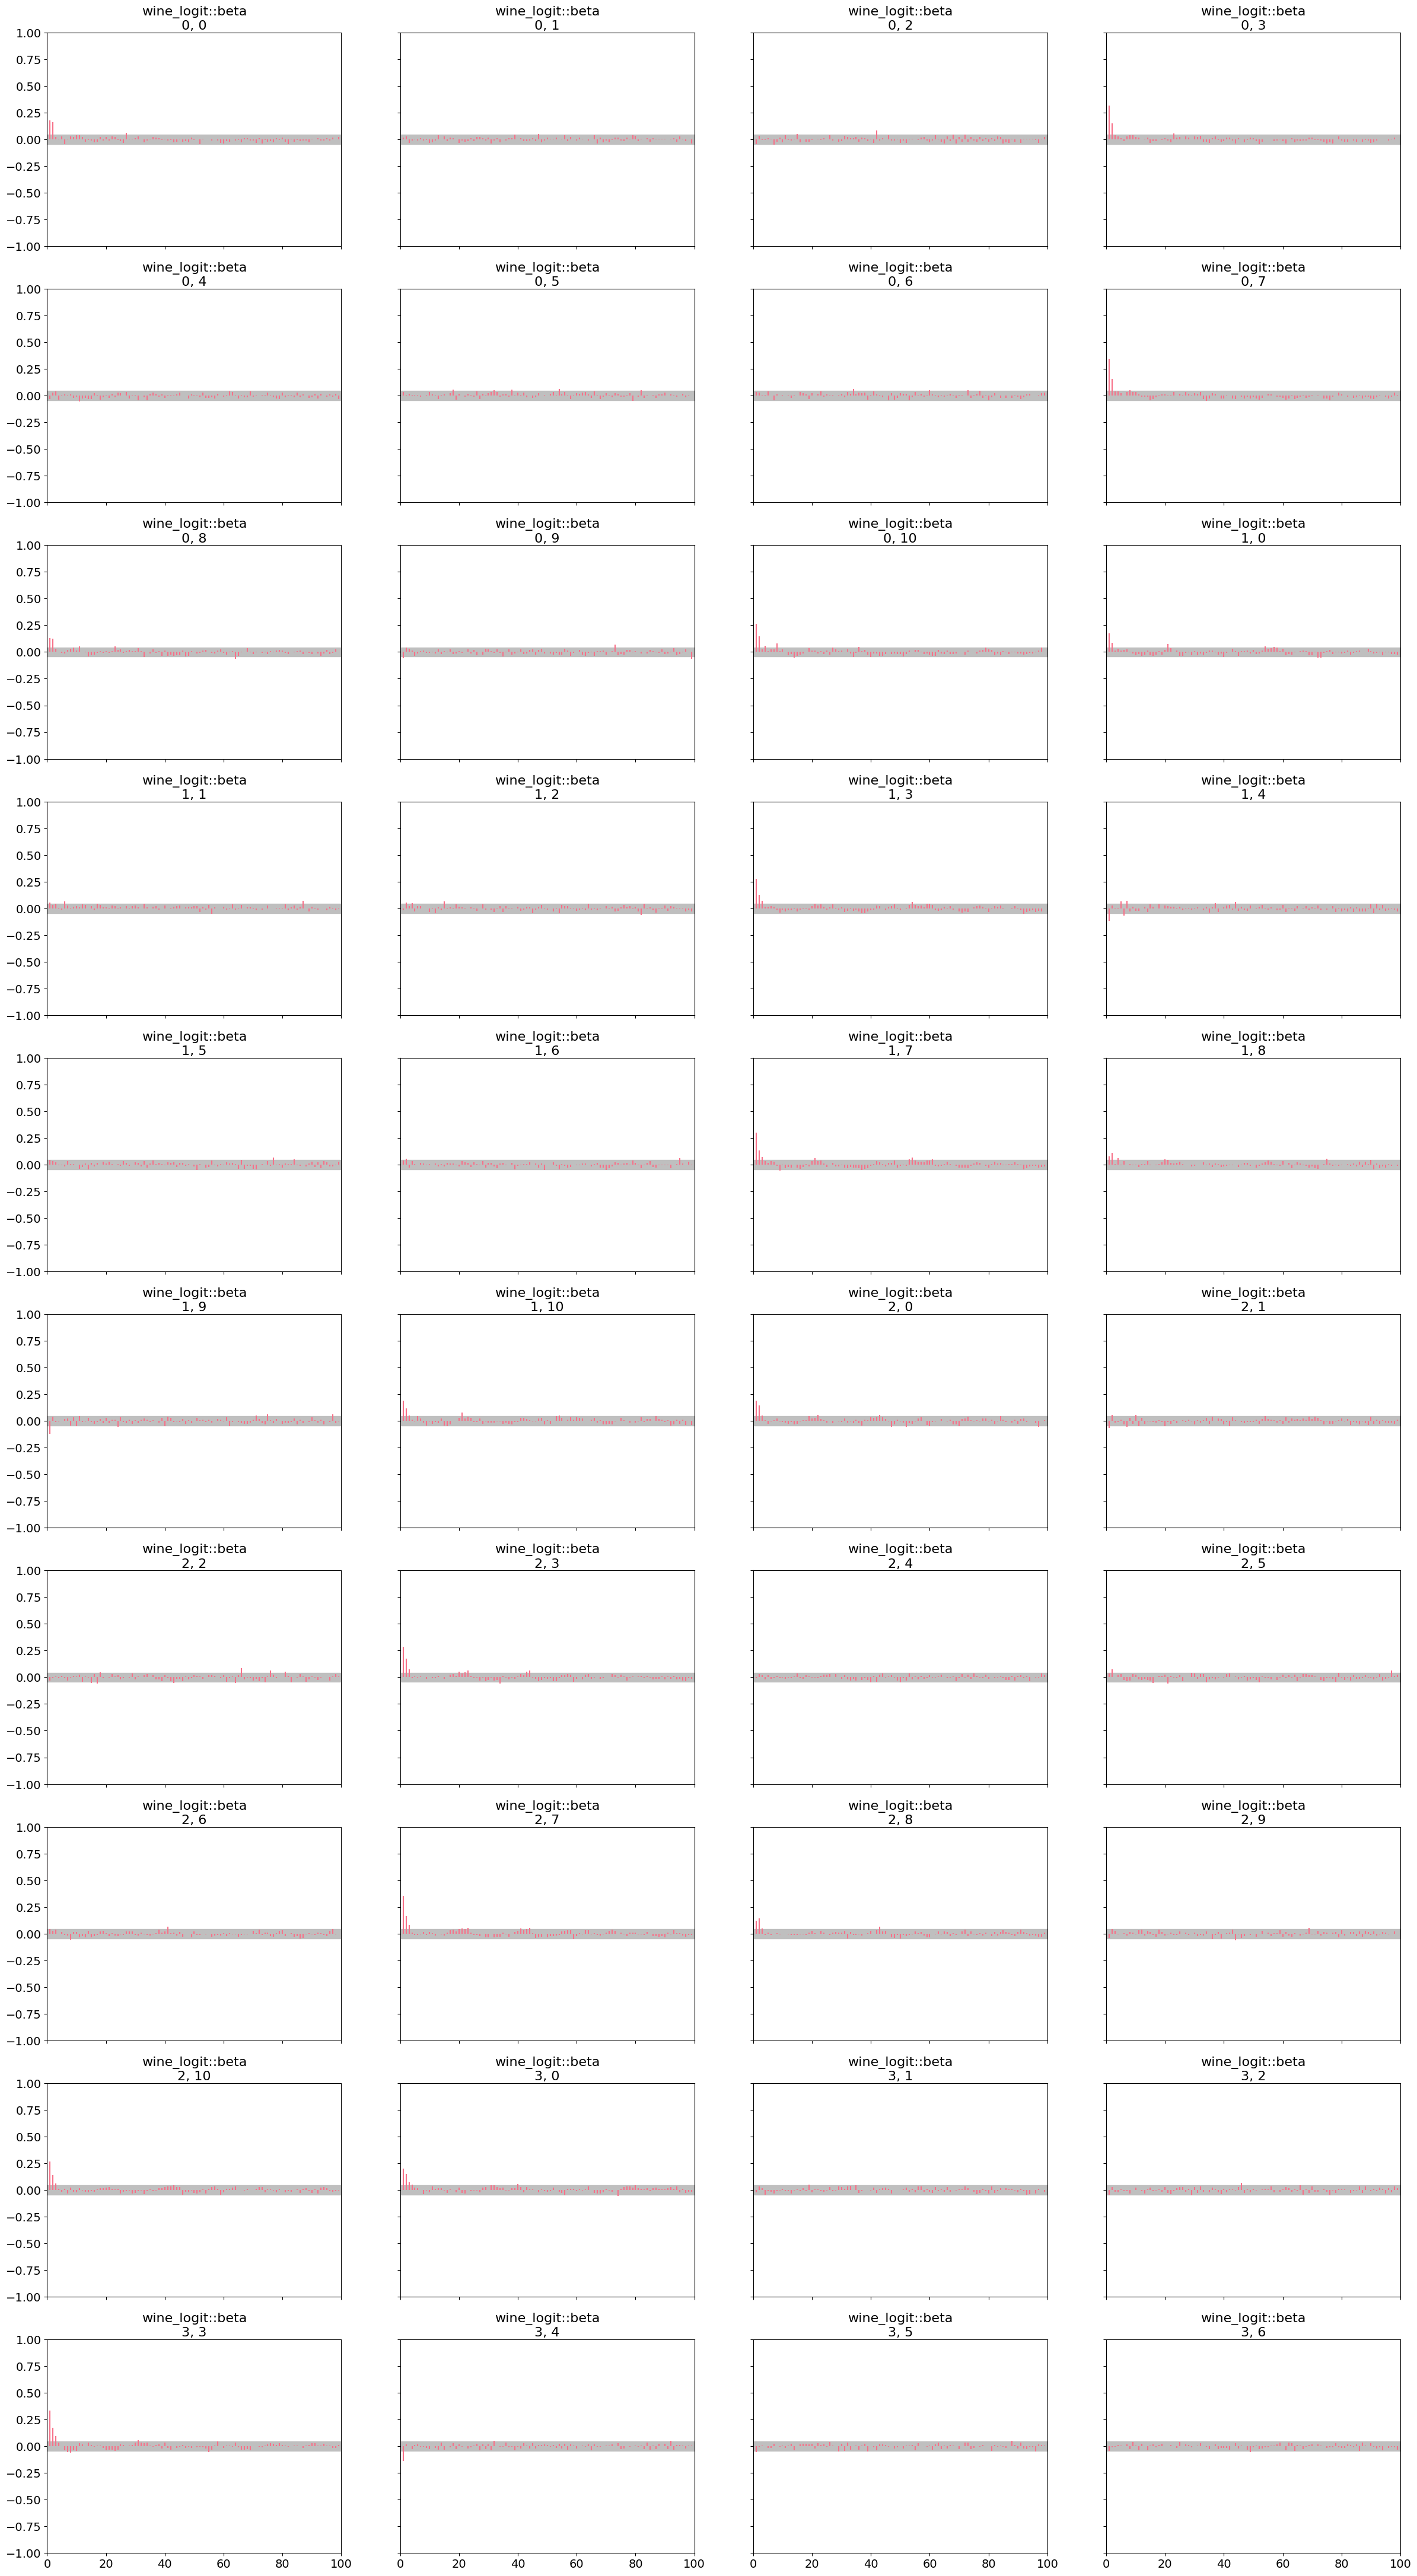

 Diagnostic plots completed
 Log likelihood available for LOO/WAIC calculations
  Max R-hat: 1.000
 Diagnostic summary completed
  Model: wine_probit
  Summary shape: (34303, 12)
  R-hat column exists: True
  R-hat values: [1. 1. 1. ... 1. 1. 1.]
Creating diagnostic plots...
 Creating energy plot...


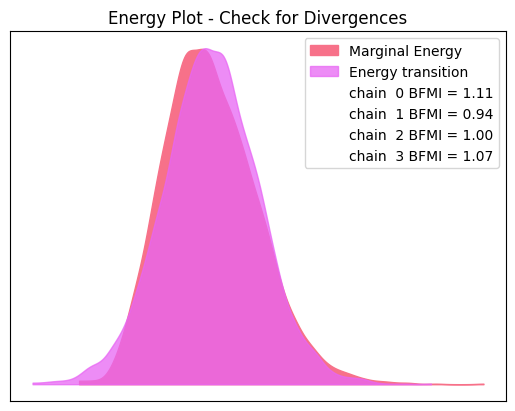

 Creating trace plots...


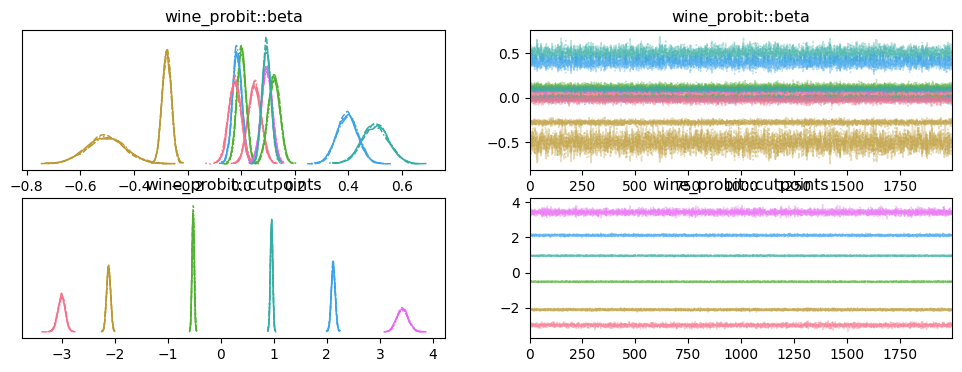

 Creating rank plots...


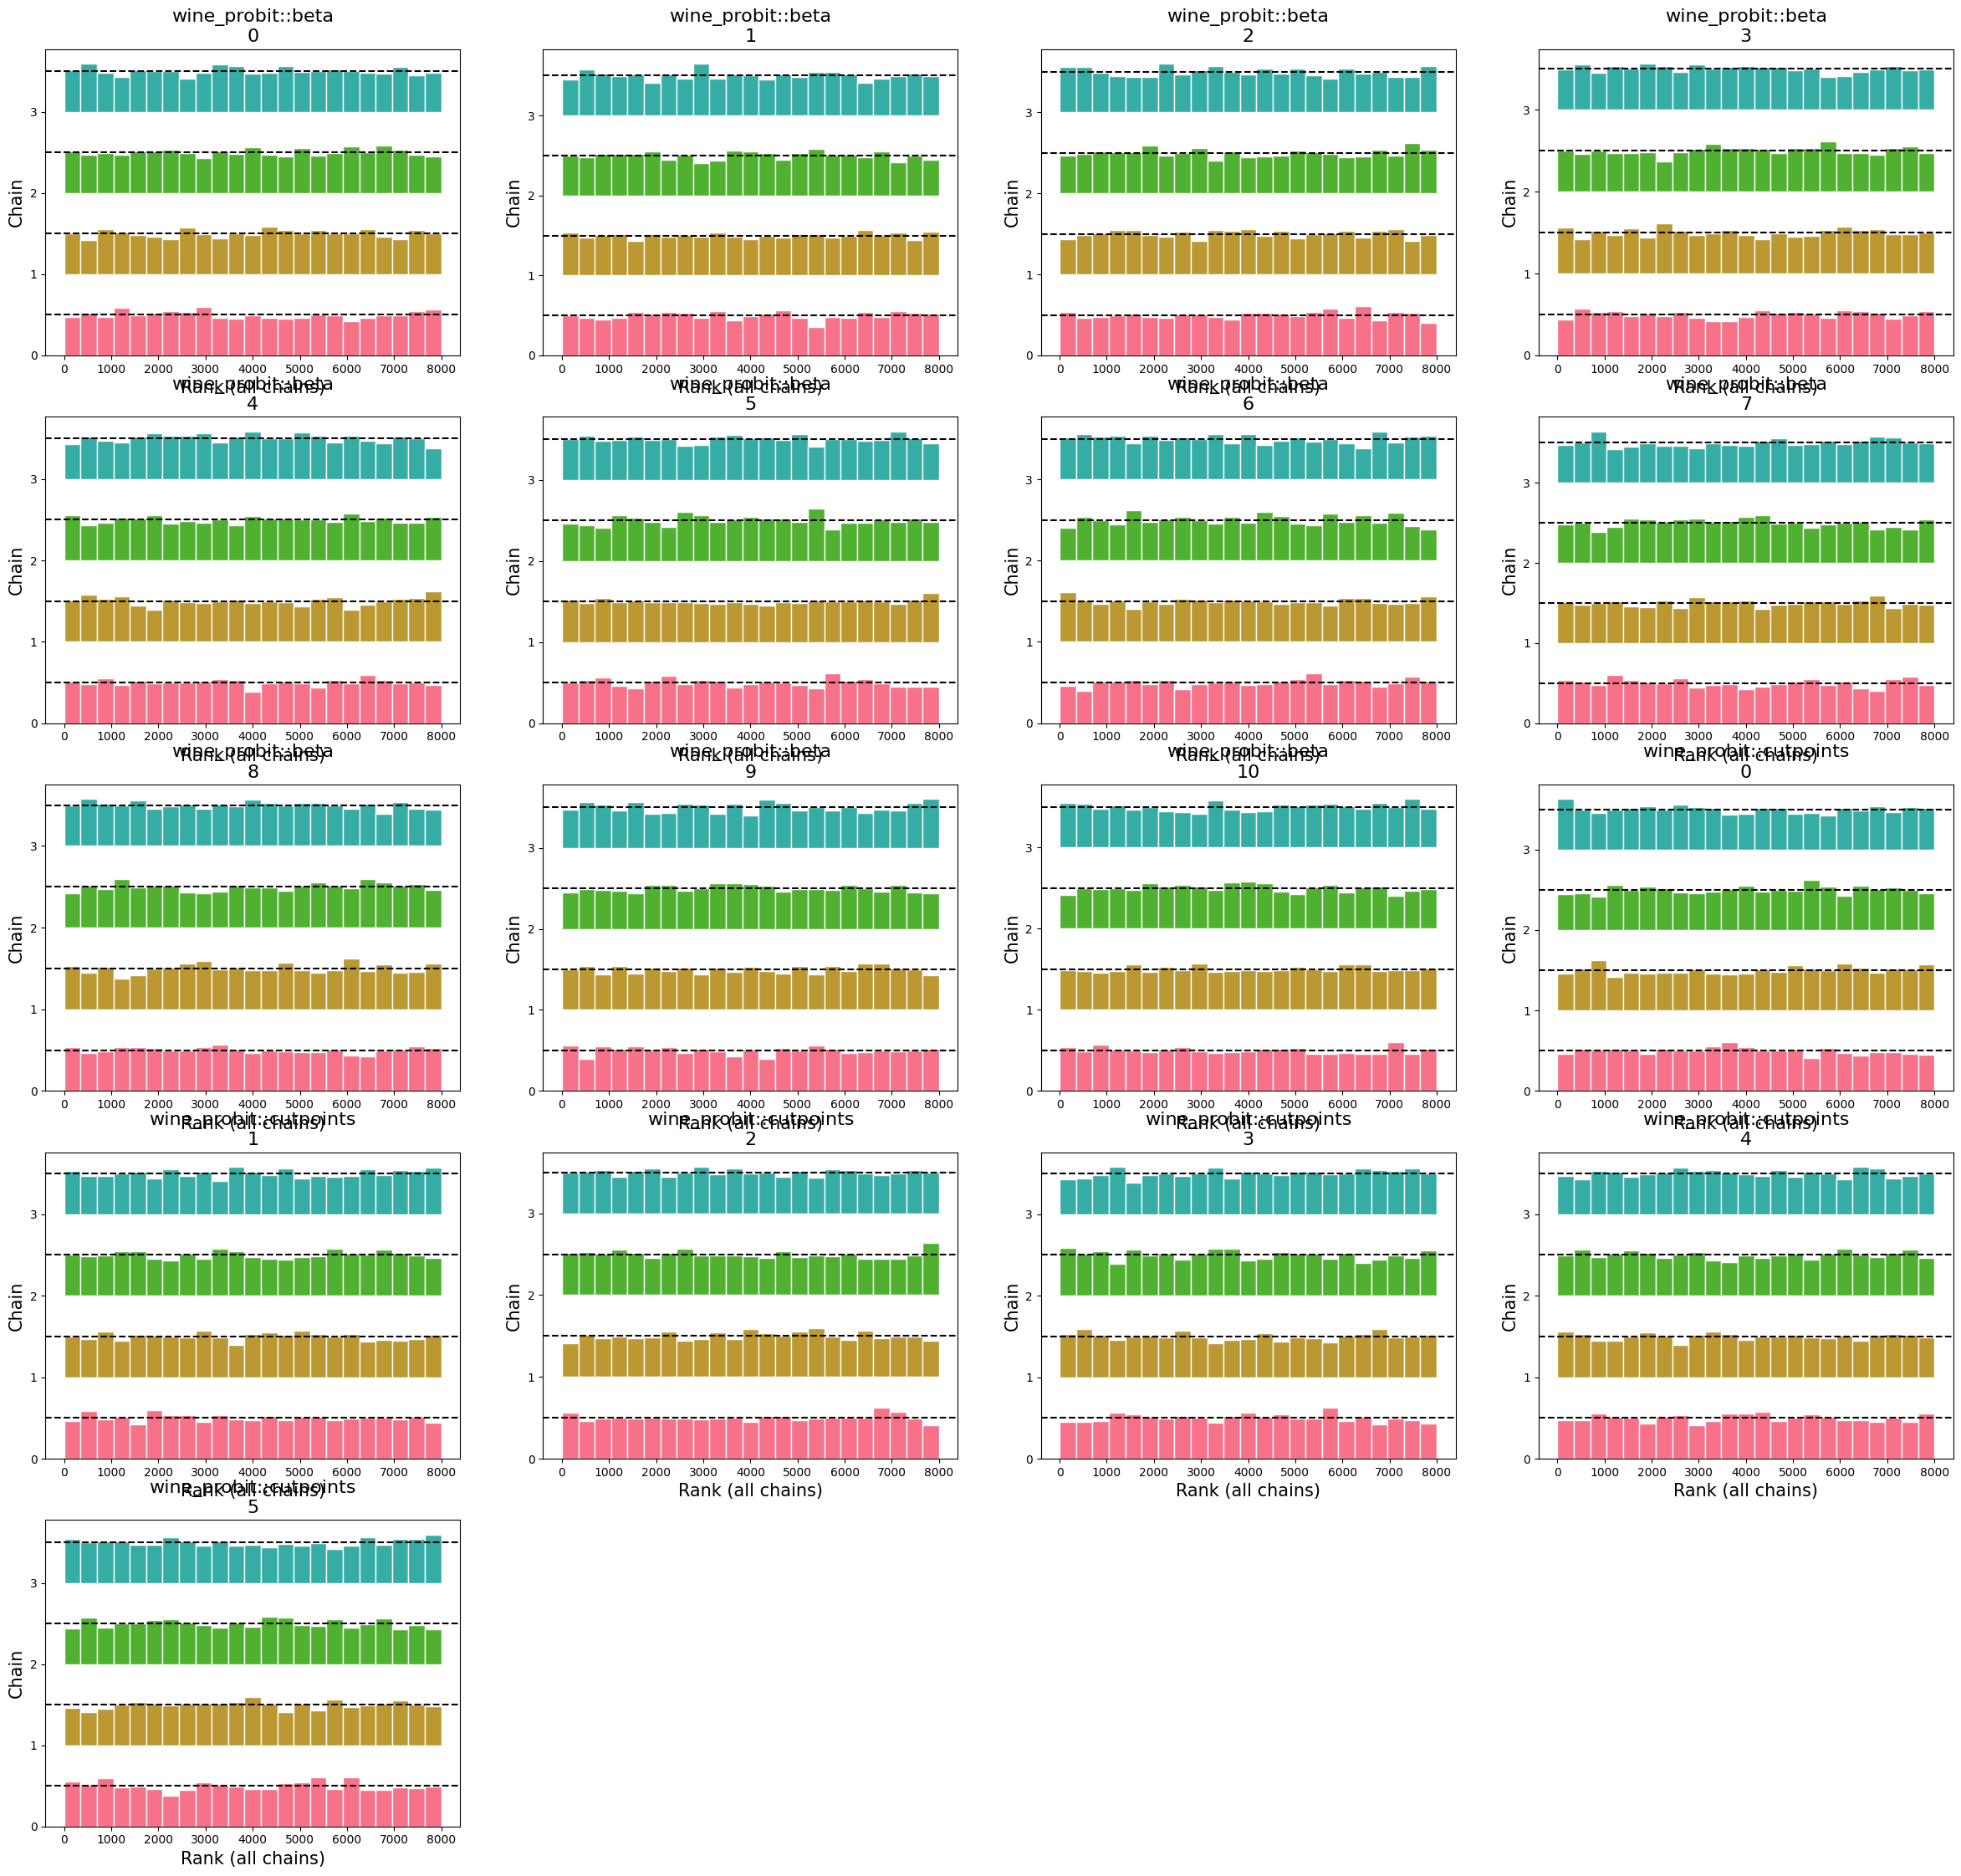

 Creating autocorrelation plots...


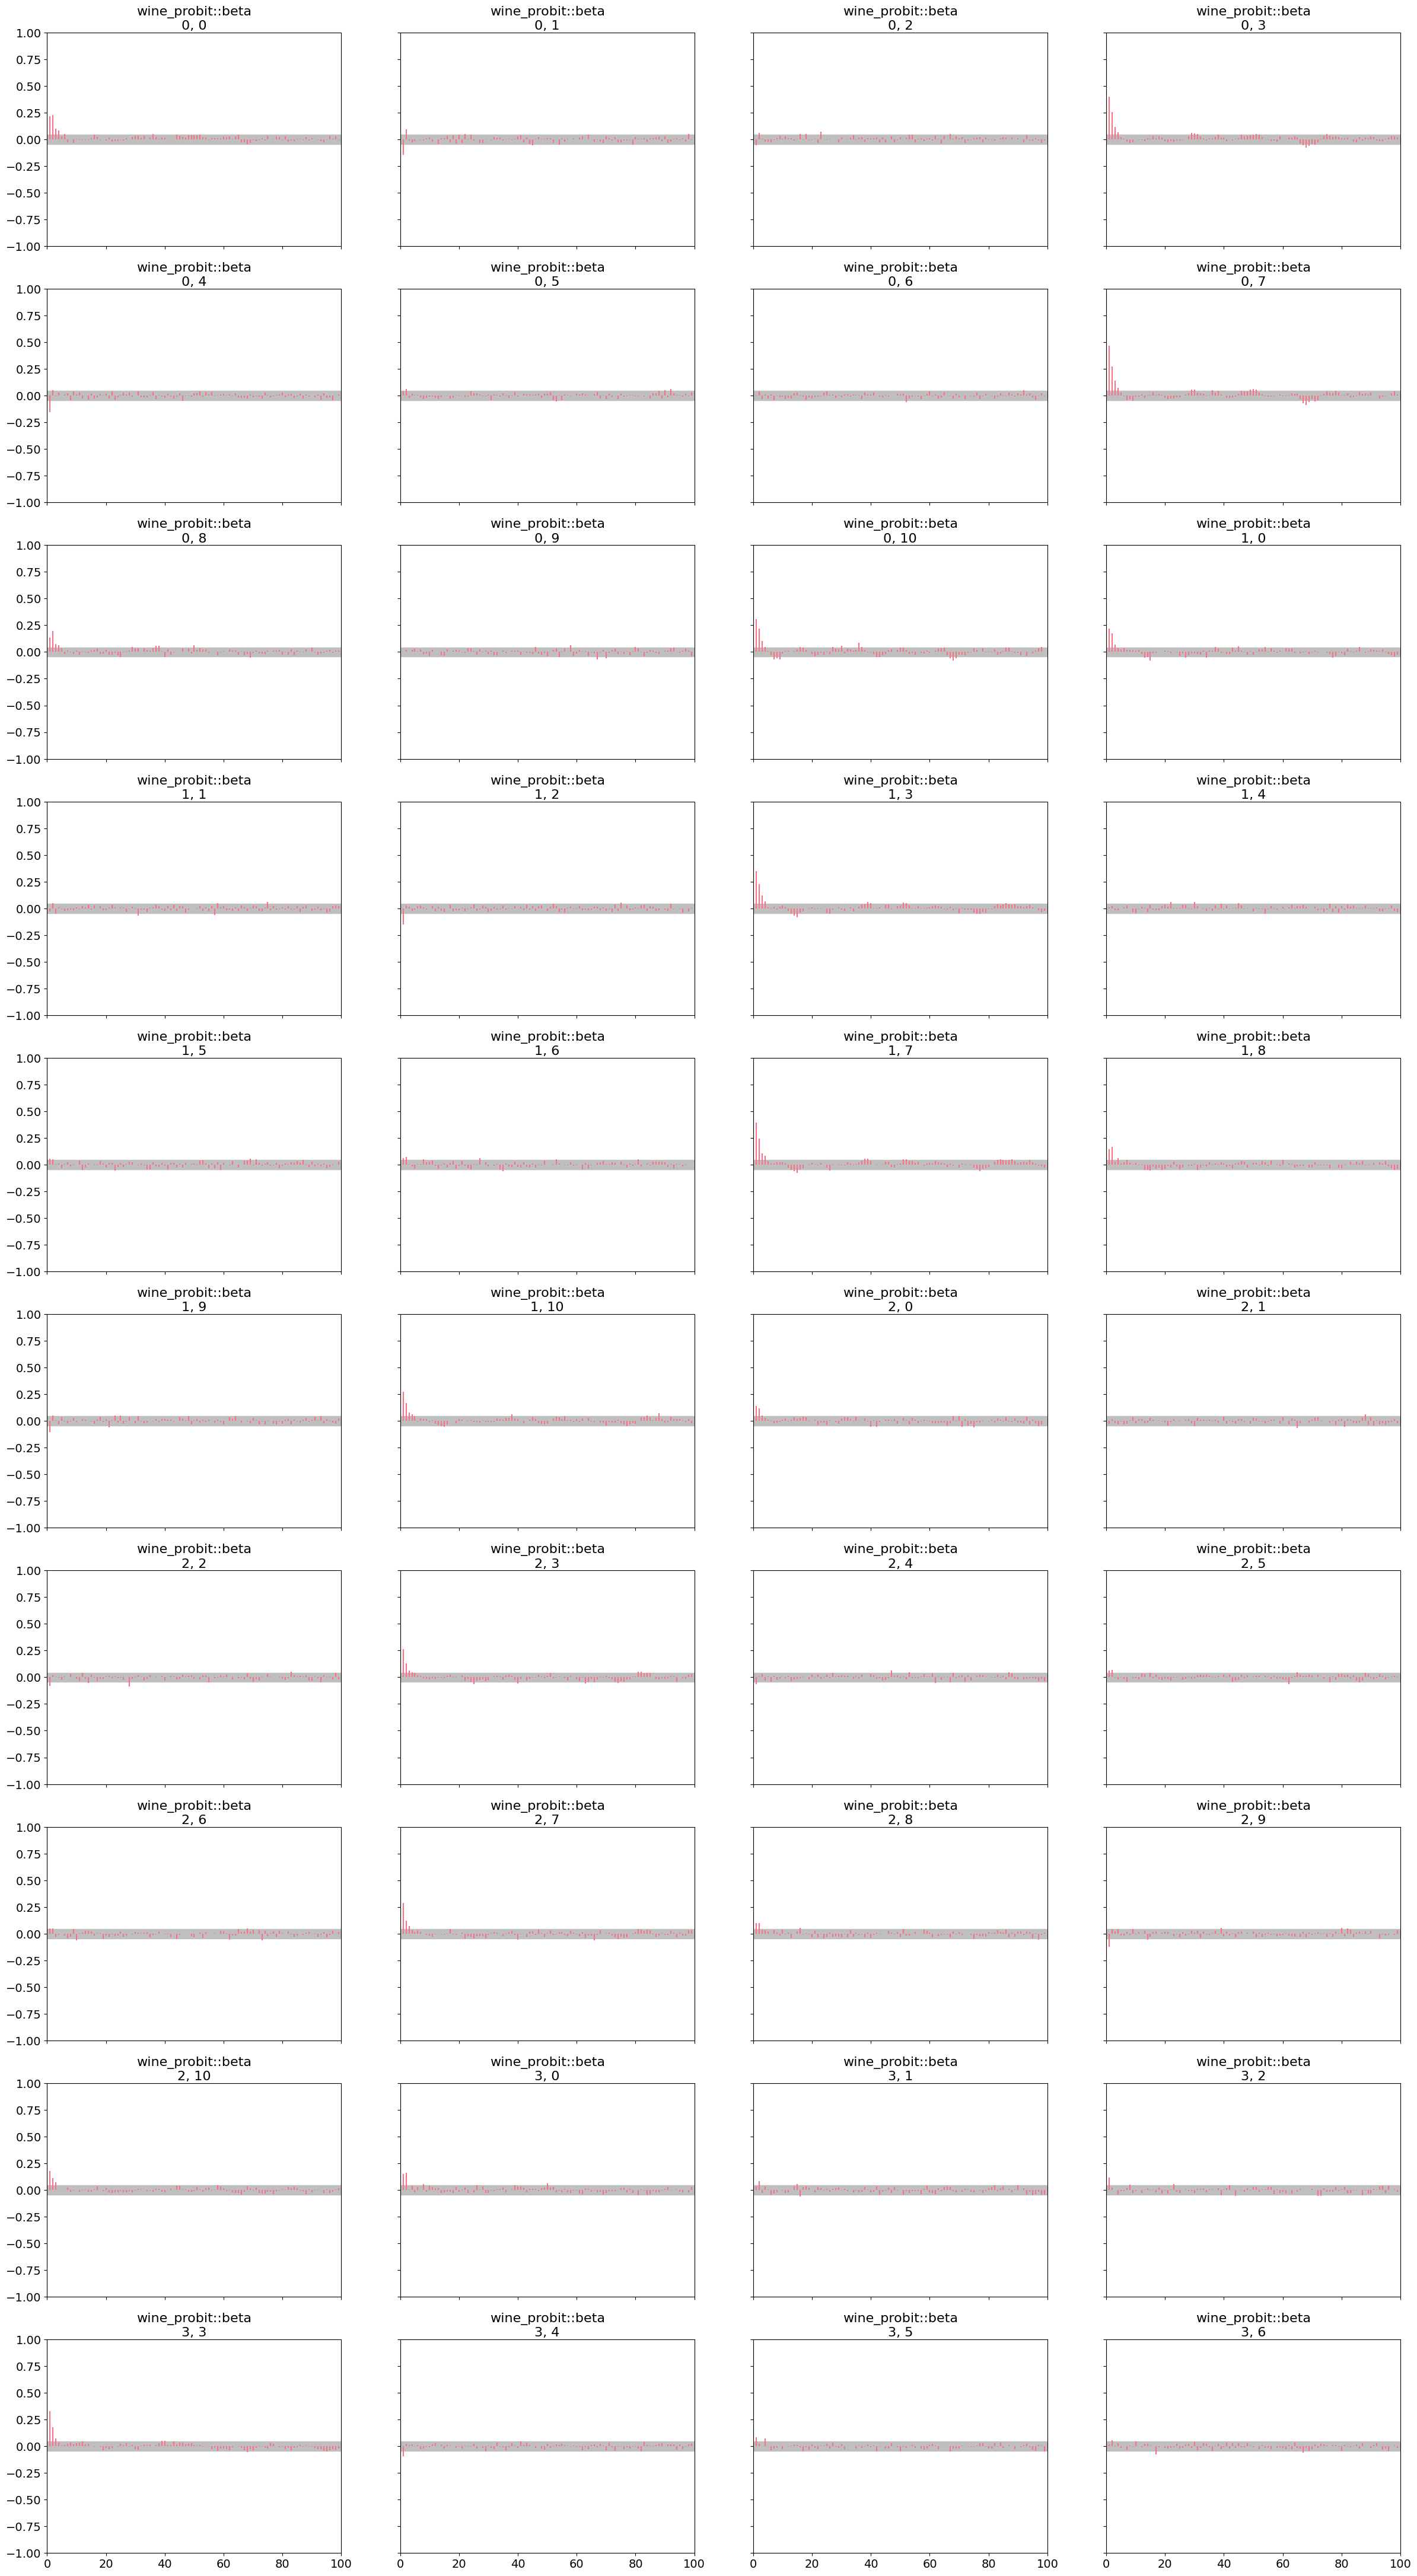

 Diagnostic plots completed

 Convergence Diagnostic Summary:
Logit Model:
   Max R-hat: 1.000
   Min ESS: 3593
   Divergences: 0
Probit Model:
   Max R-hat: 1.000
   Min ESS: 3046
   Divergences: 0

Parameter Summaries:

Logit Model Parameters:
                           mean     sd  hdi_3%  hdi_97%  ess_bulk  r_hat
wine_logit::beta[0]       0.096  0.043   0.020    0.180  4451.682  1.000
wine_logit::beta[1]      -0.458  0.029  -0.511   -0.401  7476.511  1.000
wine_logit::beta[2]       0.010  0.029  -0.045    0.064  8083.305  1.001
wine_logit::beta[3]       0.833  0.091   0.661    1.004  3794.847  1.000
wine_logit::beta[4]      -0.028  0.029  -0.085    0.024  8589.474  1.000
wine_logit::beta[5]       0.199  0.037   0.130    0.265  7179.550  1.001
wine_logit::beta[6]      -0.060  0.040  -0.133    0.017  7098.757  1.000
wine_logit::beta[7]      -0.889  0.141  -1.158   -0.632  3592.699  1.000
wine_logit::beta[8]       0.221  0.039   0.147    0.294  4786.079  1.000
wine_logit::beta[9]     

In [11]:
print("\n9. Model Diagnostics...")
print("=" * 50)

print("Running comprehensive convergence diagnostics...")

logit_diagnostics = bo.run_comprehensive_diagnostics(
    idata=idata_logit,
    model_name="wine_logit",
    include_plots=True,
    include_summary=True
)

probit_diagnostics = bo.run_comprehensive_diagnostics(
    idata=idata_probit,
    model_name="wine_probit",
    include_plots=True,
    include_summary=True
)

print(f"\n Convergence Diagnostic Summary:")
print(f"Logit Model:")
print(f"   Max R-hat: {logit_diagnostics.get('max_rhat', 'N/A'):.3f}")
print(f"   Min ESS: {logit_diagnostics.get('min_ess', 'N/A'):.0f}")
print(f"   Divergences: {logit_diagnostics.get('n_divergences', 0)}")

print(f"Probit Model:")
print(f"   Max R-hat: {probit_diagnostics.get('max_rhat', 'N/A'):.3f}")
print(f"   Min ESS: {probit_diagnostics.get('min_ess', 'N/A'):.0f}")
print(f"   Divergences: {probit_diagnostics.get('n_divergences', 0)}")

# Parameter summaries
print("\nParameter Summaries:")
print("===================")

print("\nLogit Model Parameters:")
logit_summary = az.summary(
    idata_logit, 
    var_names=["wine_logit::beta", "wine_logit::cutpoints"],
    round_to=3
)
print(logit_summary[['mean', 'sd', 'hdi_3%', 'hdi_97%', 'ess_bulk', 'r_hat']])

print("\nProbit Model Parameters:")
probit_summary = az.summary(
    idata_probit, 
    var_names=["wine_probit::beta", "wine_probit::cutpoints"],
    round_to=3
)
print(probit_summary[['mean', 'sd', 'hdi_3%', 'hdi_97%', 'ess_bulk', 'r_hat']])

print(" Model diagnostics completed successfully")

Sampling: [wine_logit::y]



10. Posterior Predictive Checks...
Running posterior predictive checks for both models...

Logit Model - Histogram check:


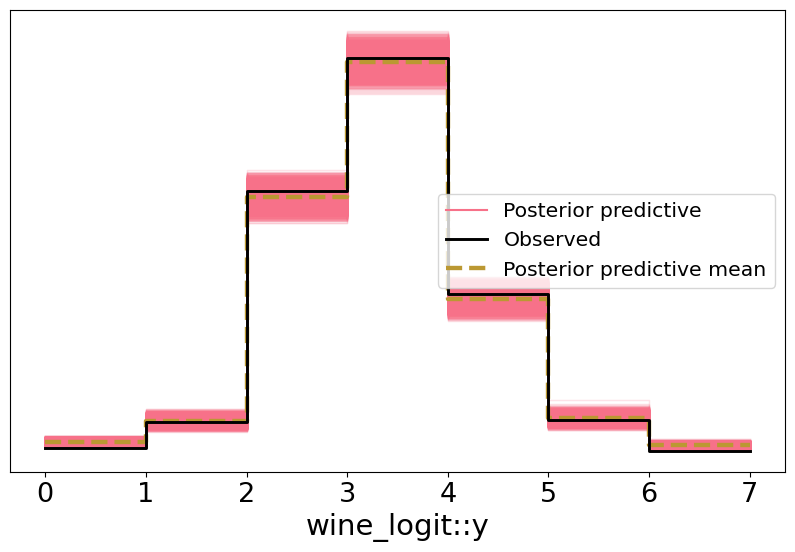

Sampling: [wine_logit::y]



Logit Model - ECDF check:


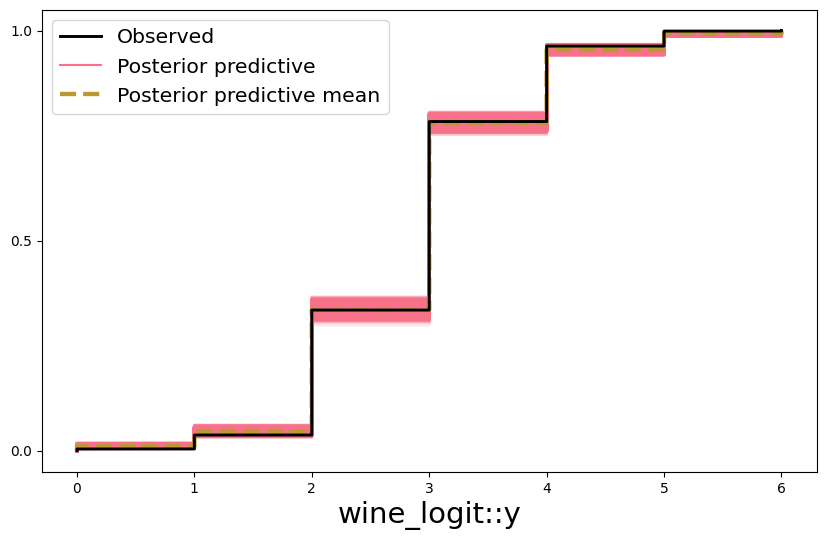

Sampling: [wine_probit::y]



Probit Model - Proportions check:


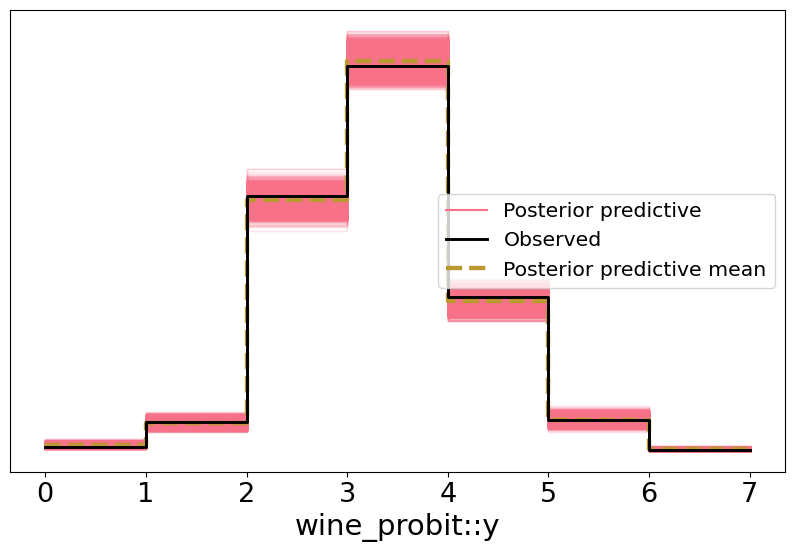

Sampling: [wine_probit::y]



Probit Model - Histogram check:


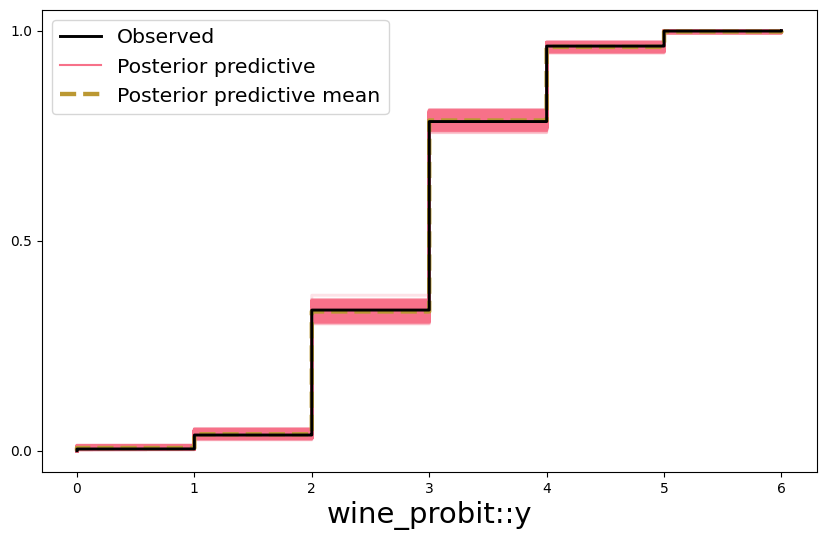

 Posterior predictive checks completed for both models


In [12]:
print("\n10. Posterior Predictive Checks...")
print("=" * 50)

# Import posterior predictive functions
from bayes_ordinal.workflow.posterior_predictive import run_posterior_predictive

print("Running posterior predictive checks for both models...")

# Logit model posterior predictive checks
print("\nLogit Model - Histogram check:")
ppc_logit_hist = run_posterior_predictive(
    model=logit_model,
    idata=idata_logit,
    var_name="wine_logit::y",
    kind="hist",
    figsize=(10, 6)
)

print("\nLogit Model - ECDF check:")
ppc_logit_ecdf = run_posterior_predictive(
    model=logit_model,
    idata=idata_logit,
    var_name="wine_logit::y",
    kind="ecdf",
    figsize=(10, 6)
)

# Probit model posterior predictive checks
print("\nProbit Model - Proportions check:")
ppc_probit_hist = run_posterior_predictive(
    model=probit_model,
    idata=idata_probit,
    var_name="wine_probit::y",
    kind="hist",
    figsize=(10, 6)
)

print("\nProbit Model - Histogram check:")
ppc_probit_ecdf = run_posterior_predictive(
    model=probit_model,
    idata=idata_probit,
    var_name="wine_probit::y",
    kind="ecdf",
    figsize=(10, 6)
)

print(" Posterior predictive checks completed for both models")



11: MODEL COMPARISON
Comparing 2 models: ['Logit', 'Probit']
Running comprehensive model comparison...
 Log likelihood found for Logit
 LOO computed successfully: -5510.43 ± 52.69
 Log likelihood found for Probit
 LOO computed successfully: -5523.17 ± 58.76
 Stacking weights computed successfully
 Bayesian Model Averaging weights computed
 Comprehensive comparison completed

COMPREHENSIVE MODEL COMPARISON RESULTS

 BASIC COMPARISON:
        rank   elpd_loo   p_loo  elpd_diff  weight       se     dse  warning  \
Logit      0  11020.868  15.342      0.000   0.503  105.382   0.000    False   
Probit     1  11046.342  20.340     25.473   0.497  117.529  22.474    False   

           scale  n_bad_k  
Logit   deviance        0  
Probit  deviance        0  

 BEST MODEL: Logit

 STACKING WEIGHTS:
  Logit: 0.503
  Probit: 0.497

 BAYESIAN MODEL AVERAGING WEIGHTS:
  Logit: 0.500
  Probit: 0.500

 CONVERGENCE DIAGNOSTICS:
  Logit:  CONVERGED
    R-hat max: 1.003
    ESS min: 3593
  Probit:  CON

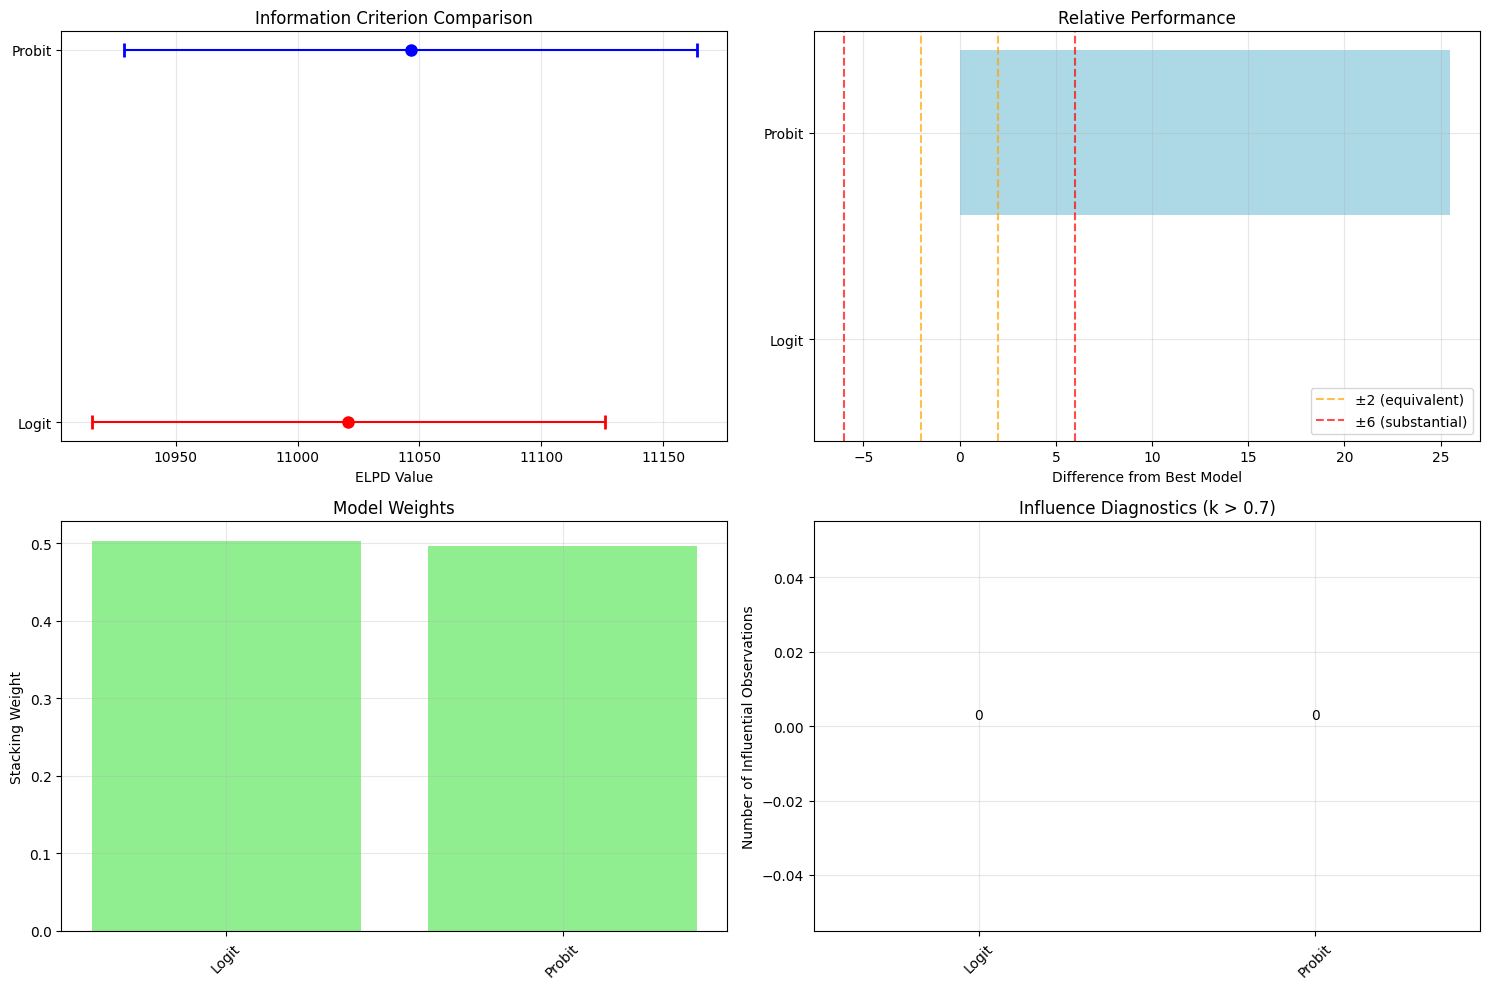


MCELREATH-STYLE MODEL COMPARISON SUMMARY
Best Model: Logit
Best Model IC Value: 11020.87

Model Interpretations:
  Logit: Best model - This model has the highest information criterion value
  Probit: Substantial difference - Difference of 25.47 is greater than 6

Recommendations:

Next Steps:
  → Perform posterior predictive checks on the selected model
  → Examine parameter estimates and their uncertainty
  → Consider sensitivity analysis for key parameters
  → If multiple models are close, use model averaging
 Model comparison and interpretation completed

 Model Comparison Summary:
**Interpretation Guidelines (McElreath style):**
- **ΔLOO < 2:** Models essentially equivalent
- **2 < ΔLOO < 6:** Moderate evidence for better model
- **ΔLOO > 6:** Strong evidence for better model

**Expected Finding:** Logit and probit models should perform very similarly


In [13]:
print("11: MODEL COMPARISON")
print("=" * 60)

# Setup model comparison
models = {
    'Logit': logit_model,
    'Probit': probit_model
}

idatas = {
    'Logit': idata_logit,
    'Probit': idata_probit
}

print(f"Comparing {len(models)} models: {list(models.keys())}")

# Import comparison functions
from bayes_ordinal.workflow.cross_validation import (
    compare_models_stacking,
    display_comparison_results,
    compare_models_interpretation,
    plot_model_comparison_interpretation
)

# Comprehensive model comparison
print("Running comprehensive model comparison...")

comparison_results = compare_models_stacking(
    models=models,
    idatas=idatas,
    ic="loo",
    include_stacking=True,
    include_bma=True
)

print(" Comprehensive comparison completed")

# Display results
display_comparison_results(comparison_results)

# McElreath-style interpretation with plots
print("\nCreating McElreath-style interpretation...")
interpretation_results = compare_models_interpretation(
    models=models,
    idatas=idatas,
    ic="loo"
)

plot_model_comparison_interpretation(interpretation_results)
print(" Model comparison and interpretation completed")

# Model comparison summary
print("\n Model Comparison Summary:")
print("**Interpretation Guidelines (McElreath style):**")
print("- **ΔLOO < 2:** Models essentially equivalent")
print("- **2 < ΔLOO < 6:** Moderate evidence for better model")
print("- **ΔLOO > 6:** Strong evidence for better model")
print("\n**Expected Finding:** Logit and probit models should perform very similarly")
